# Step 1: Import packages & Settings, Read Raw data

In [2]:
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import tldextract
import re

from gensim.test.utils import common_texts
from gensim.models import FastText

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.layers import Input, Dense
from keras_tuner import RandomSearch
from keras.utils import plot_model

C:\Users\admin\AppData\Local\Temp\ipykernel_20728\3451840247.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

In [4]:
# Load raw data
raw_data = pd.read_csv('dataset_B_05_2020.csv')

In [5]:
raw_data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.75,7.00,4.50,0,0,0,0,0,0,17,0.53,0.47,0,0,0,0.88,0,0.50,0,0,80.00,0,100.00,0.00,0,0,0,0.00,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.22,0.00,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.75,19.00,14.67,0,0,0,0,0,0,30,0.97,0.03,0,0,0,0.00,0,0.00,0,0,100.00,0,80.00,20.00,0,0,0,100.00,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.15,0.00,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.25,8.40,8.14,0,0,0,0,0,0,4,1.00,0.00,0,0,0,0.00,0,0.00,0,0,100.00,0,0.00,0.00,0,0,0,100.00,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.00,0.00,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.00,5.00,0.00,0,0,0,0,0,0,149,0.97,0.03,0,0,0,0.25,0,0.25,0,0,100.00,0,96.43,3.57,0,0,0,62.50,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.00,0.00,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.33,5.00,7.00,0,0,0,0,0,0,102,0.47,0.53,0,0,0,0.54,0,0.02,1,0,76.47,0,0.00,100.00,0,0,0,0.00,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate


In [6]:
print(raw_data.shape)

(11430, 89)


# Step 2: Data Processing
- In the following sections, we will do data processing on `web` dataframe, which is a copy of our raw data.
- Due to large number of features, we only show processing on features that need to be processed.

In [7]:
web = raw_data.copy()

## Response Fature

status
legitimate    5715
phishing      5715
Name: count, dtype: int64


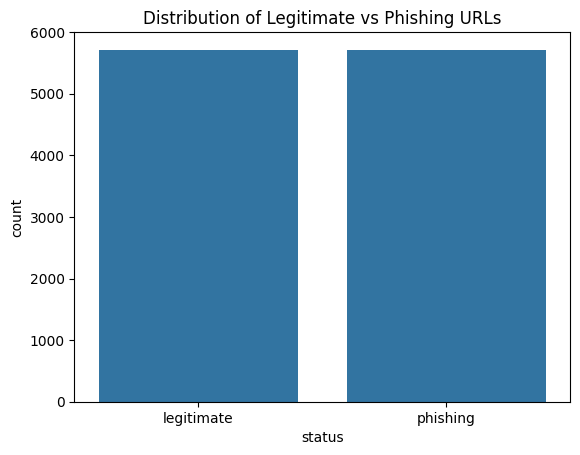

In [8]:
# Check target distribution
print(web['status'].value_counts())
# Visualize the distribution
sns.countplot(data=web, x='status')
plt.title("Distribution of Legitimate vs Phishing URLs")
plt.show()

### Response feature encoding
- The response feature `status` is string categorical data, we will encode phishing as 1, legitimate as 0

In [9]:
web['status'] = web['status'].map({'phishing': 1, 'legitimate': 0})

## Predictive Features

### Words extraction

To process the url text, we first lower the text, and then extract the phrase in the url by taking symbols as separator. Unlike traditional language preprocessing, we did not apply lemmatization and did not remove any 'stop word'. The reasons are as the following:
- Lemmatization: Lemmatizing the words might lose subtle but important variations, especially when phishing websites exploit small character differences or typos to deceive users (like google vs. g00gle, and apple vs apples). Lemmatizing may normalize words in a way that removes key information related to these subtle differences.

- Stop Word Removal: While removing stop words (common words like "and," "the," "of") can reduce noise in traditional natural language processing tasks, in the case of phishing detection, every part of the URL could carry important information. Phishing websites often manipulate even minor details to deceive users, so even common words or filler words might contribute to distinguishing a legitimate URL from a phishing one.

We extracted phrases and words in `url` and save them in a list, which is stored in feature named `words_raw`

In [10]:
def words_raw_extraction(domain, subdomain, path):
        w_domain = re.split("\-|\.|\/|\?|\=|\@|\&|\%|\:|\_", domain.lower())
        w_subdomain = re.split("\-|\.|\/|\?|\=|\@|\&|\%|\:|\_", subdomain.lower())
        w_path = re.split("\-|\.|\/|\?|\=|\@|\&|\%|\:|\_", path.lower())
        raw_words = w_domain + w_path + w_subdomain
        w_host = w_domain + w_subdomain
        raw_words = list(filter(None,raw_words))
        return raw_words, list(filter(None,w_host)), list(filter(None,w_path))

def get_info(url):
    extracted_domain = tldextract.extract(url)
    domain = extracted_domain.domain
    subdomain = extracted_domain.subdomain
    tmp = url[url.find(extracted_domain.suffix):len(url)]
    pth = tmp.partition("/")
    words_raw, words_raw_host, words_raw_path= words_raw_extraction(domain, subdomain, pth[2])
    return words_raw

In [11]:
web['words_raw'] = web['url'].apply(get_info)
web.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status,words_raw
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.75,7.00,4.50,0,0,0,0,0,0,17,0.53,0.47,0,0,0,0.88,0,0.50,0,0,80.00,0,100.00,0.00,0,0,0,0.00,0,0,0,0,1,0,45,-1,0,1,1,4,0,"[crestonwood, router, php, www]"
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.22,0.00,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.75,19.00,14.67,0,0,0,0,0,0,30,0.97,0.03,0,0,0,0.00,0,0.00,0,0,100.00,0,80.00,20.00,0,0,0,100.00,0,0,0,1,0,0,77,5767,0,0,1,2,1,"[shadetreetechnology, v4, validation, a111aedc..."
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.15,0.00,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.25,8.40,8.14,0,0,0,0,0,0,4,1.00,0.00,0,0,0,0.00,0,0.00,0,0,100.00,0,0.00,0.00,0,0,0,100.00,0,0,0,1,0,0,14,4004,5828815,0,1,0,1,"[duilawyeryork, ap, 89e6a3b4b063b8d, cmd, upda..."
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.00,0.00,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.00,5.00,0.00,0,0,0,0,0,0,149,0.97,0.03,0,0,0,0.25,0,0.25,0,0,100.00,0,96.43,3.57,0,0,0,62.50,0,0,0,1,0,0,62,-1,107721,0,0,3,0,[rgipt]
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.00,0.00,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.33,5.00,7.00,0,0,0,0,0,0,102,0.47,0.53,0,0,0,0.54,0,0.02,1,0,76.47,0,0.00,100.00,0,0,0,0.00,0,0,0,0,1,0,224,8175,8725,0,0,6,0,"[iracing, tracks, gateway, motorsports, park, ..."


### Missing values

We discover that, there is no null values in the data set. However, through our observation, we realize that the negative values in `domain_registration_length` and `domain_age` represent missing values, due to unavailable information during data collection. This means that, we need to replace negative values with `np.NaN`, showing that they are missing values.
- For `domain_registration_length`, only 46 out of the 11430 (0.4%) values are negative, therefore, it is safe to drop these data points.
- For `domain_age`, 1837 out of 11430 (16.1%) values are negative. In this case, dropping data points will cause information loss. This will be handled after train test split.

After removing data entries with missing `domain_registration_length`, we have 11384 entries left.

In [12]:
# Replace negative values with NaN
web['domain_registration_length'] = web['domain_registration_length'].apply(lambda x: np.nan if x < 0 else x)
web['domain_age'] = web['domain_age'].apply(lambda x: np.nan if x < 0 else x)

# Drop rows with null values in 'domain_registration_length'
web.dropna(subset=['domain_registration_length'], inplace=True)

print(web.shape)

(11384, 90)


### Duplicates

There is no duplicates in the dataset

In [13]:
to_be_checked = web.copy().drop('words_raw', axis = 1)

to_be_checked.duplicated().sum()

0

### Drop meaningless features

Some features only have one value, which is not helpful in make prediction and can be removed:
- nb_or
- ratio_nullHyperlinks
- ratio_intRedirection
- ratio_intErrors
- submit_email
- sfh

In [14]:
web = web.drop(['nb_or', 'ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'submit_email', 'sfh'], axis=1)
web.shape


(11384, 84)

### Categorical & Numerical features

In [15]:
categorical_cols = ['ip',
           'https_token',
           'punycode',
           'port',
           'tld_in_path',
           'tld_in_subdomain',
           'abnormal_subdomain',
           'prefix_suffix',
           'random_domain',
           'shortening_service',
           'path_extension',
           'domain_in_brand',
           'brand_in_subdomain',
           'brand_in_path',
           'suspecious_tld',
           'login_form',
           'external_favicon',
           'iframe',
           'popup_window',
           'onmouseover',
           'right_clic',
           'empty_title',
           'domain_in_title',
           'domain_with_copyright',
           'whois_registered_domain',
           'dns_record',
           'google_index']

numerical_cols = ['length_url',
          'length_hostname',
          'nb_dots',
          'nb_hyphens',
          'nb_at',
          'nb_qm',
          'nb_and',
          'nb_eq',
          'nb_underscore',
          'nb_tilde',
          'nb_percent',
          'nb_slash',
          'nb_star',
          'nb_colon',
          'nb_comma',
          'nb_semicolumn',
          'nb_dollar',
          'nb_space',
          'nb_www',
          'nb_com',
          'nb_dslash',
          'http_in_path',
          'ratio_digits_url',
          'ratio_digits_host',
          'nb_subdomains',
          'nb_redirection',
          'nb_external_redirection',
          'length_words_raw',
          'char_repeat',
          'shortest_words_raw',
          'shortest_word_host',
          'shortest_word_path',
          'longest_words_raw',
          'longest_word_host',
          'longest_word_path',
          'avg_words_raw',
          'avg_word_host',
          'avg_word_path',
          'phish_hints',
          'statistical_report',
          'nb_hyperlinks',
          'ratio_intHyperlinks',
          'ratio_extHyperlinks',
          'nb_extCSS',
          'ratio_extRedirection',
          'ratio_extErrors',
          'links_in_tags',
          'ratio_intMedia',
          'ratio_extMedia',
          'safe_anchor',
          'domain_registration_length',
          'domain_age',
          'web_traffic',
          'page_rank']

We use boxplot, countplot, histplot to explore the distribution of all the features in the dataset. This is to decide whether there is any problem on the feature to be adjusted

### Box plot and Outliers

From the plots below, we could observe that there are some outliers for the features.

In the context of phishing page detection, there are several reasons why we should not remove outliers in the dataset.
  1. Outliers as Key Indicators of Phishing
  Phishing pages often exhibit extreme values, features like `length_url`, `nb_hypen`, `nb_and` which are indicating the length of the url link and number of special characters, or the presence of certain unusual patterns, could naturally appear as outliers when compared to legitimate websites. Removing these outliers might lead to the removal of essential phishing features that could help to distinguish phishing pages from normal ones.
  2. Phishing is inherently an outlier problem
  Phishing detection is often about finding anomalies. Phishing sites typically deviate from standard patterns of legitimate sites, making them outliers in the dataset. The very nature of phishing detection is to identify these anomalies, so removing outliers would reduce the model's ability to detect them.
  3. Potential loss of important information
  In some cases, outliers could represent edge cases. In cybersecurity, the ability to handle edge cases is critical. These outliers could represent novel or rare attack patterns that need to be caught. On the other hand, some legitimate websites might also exhibit outlier-like behavior. Removing these could make the model overly sensitive, leading to false positives.

In this phishing detection context, outliers may contain vital patterns needed to detect phishing attempts, so it's better for us to retain them for better model performance rather than removing them.

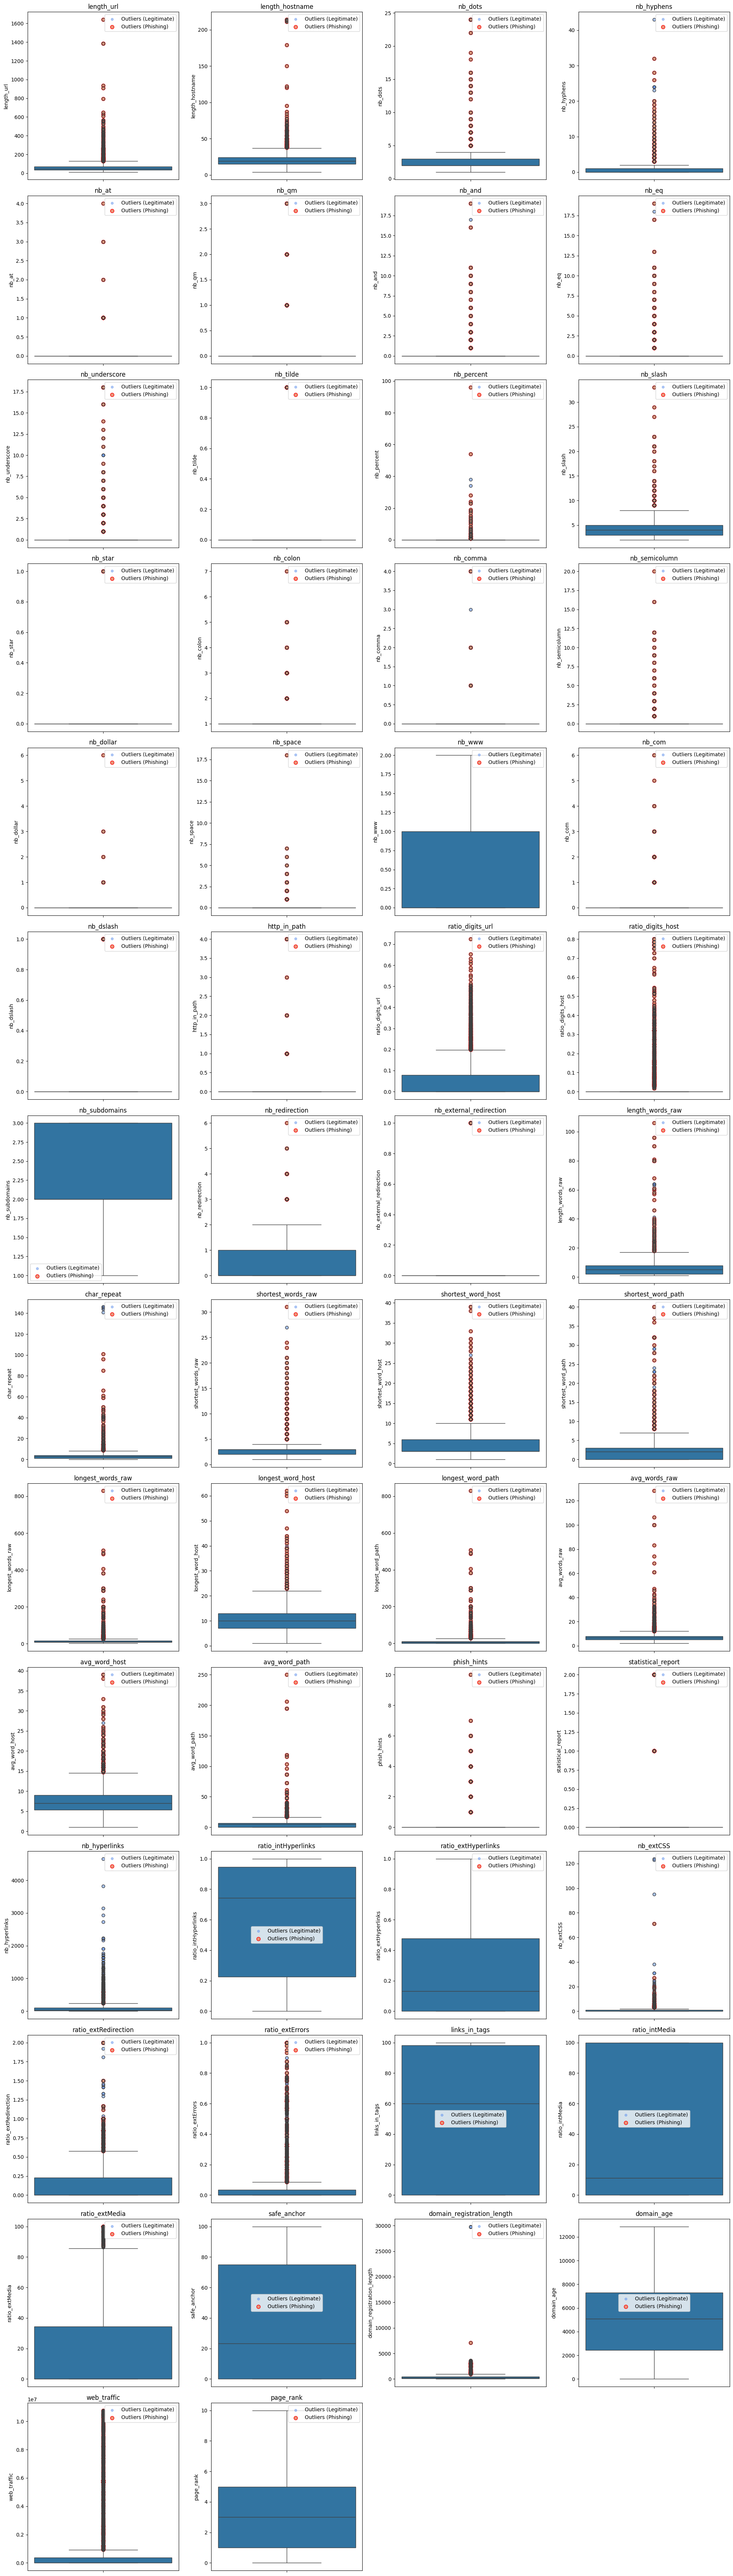

In [16]:
def plot_boxplots_with_highlighted_outliers(df, numerical_cols, target_col, highlight_class):
    n_cols = 4
    n_rows = (len(numerical_cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

    for i, col in enumerate(numerical_cols):
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i % n_cols]

        # Create box plot
        sns.boxplot(y=df[col], ax=ax)

        # Find outliers
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        highlighted_outliers = outliers[outliers[target_col] == highlight_class]

        # Plot outliers
        ax.scatter(x=np.zeros_like(outliers[col]), y=outliers[col],
                   color='CornflowerBlue', alpha=0.5, s=20, label='Outliers (Legitimate)')

        # Highlight specific class outliers
        ax.scatter(x=np.zeros_like(highlighted_outliers[col]), y=highlighted_outliers[col],
                   color='DarkSalmon', edgecolor='red', s=50, label=f'Outliers (Phishing)')

        ax.set_title(col)
        ax.legend()

    for i in range(len(numerical_cols), n_rows * n_cols):
      row = i // n_cols
      col = i % n_cols
      fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

plot_boxplots_with_highlighted_outliers(web, numerical_cols, 'status', 1)

### Count plot of categorical features

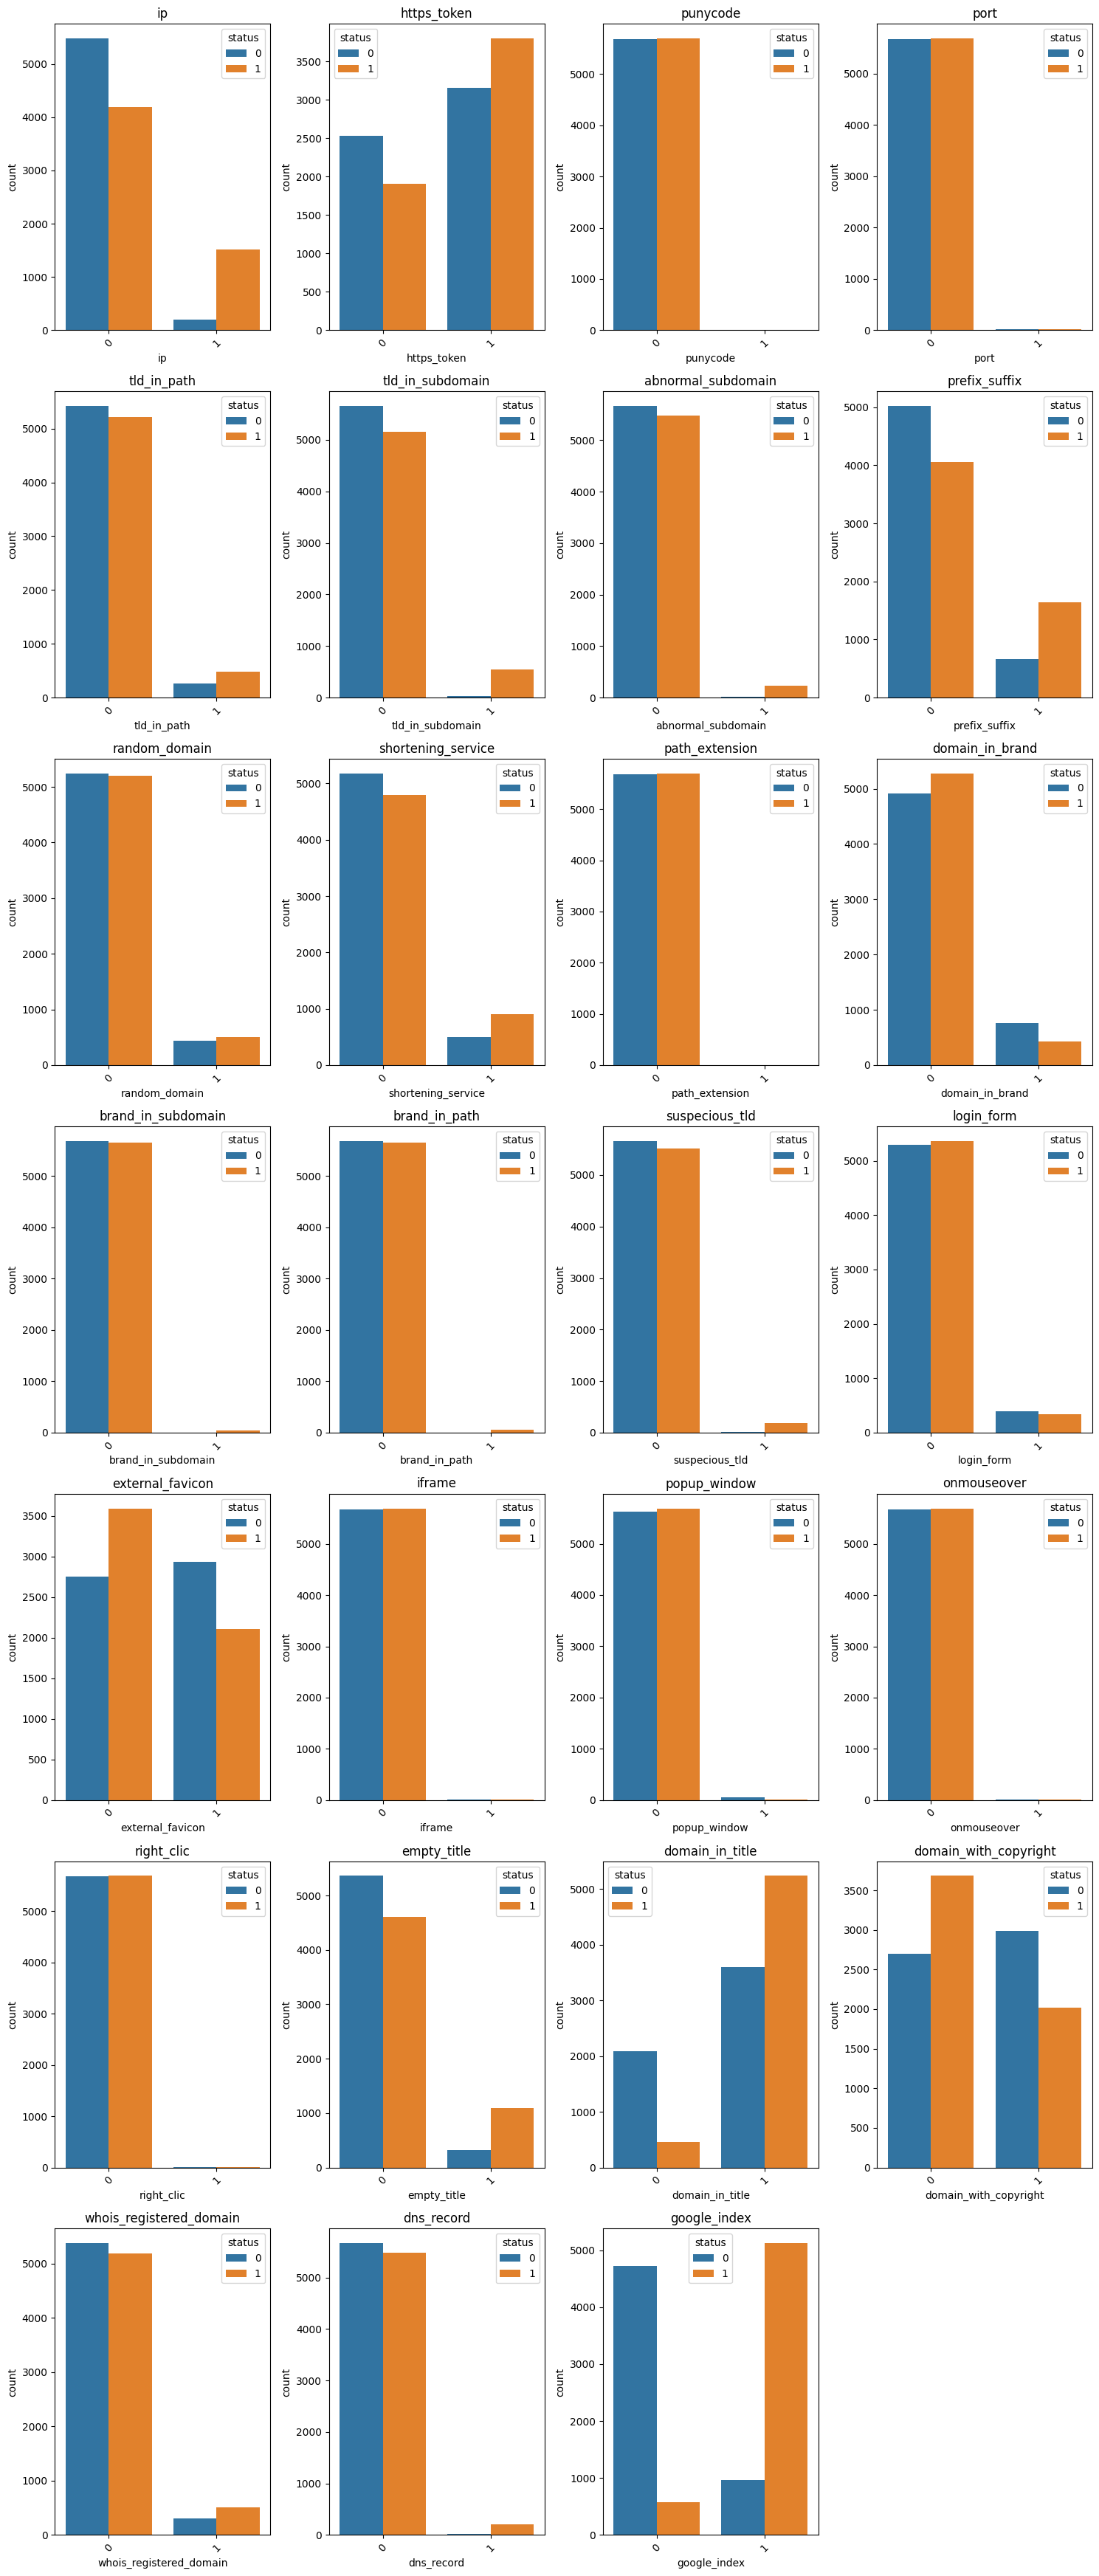

In [17]:
num_plots_per_row = 4
num_rows = (len(categorical_cols) + num_plots_per_row - 1) // num_plots_per_row


fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))

for i, feature in enumerate(categorical_cols):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.countplot(data=web, x=feature, hue='status', ax=axes[row, col])
    axes[row, col].set_title(feature)
    axes[row, col].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for i in range(len(categorical_cols), num_rows * num_plots_per_row):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


### Histogram of numerical features

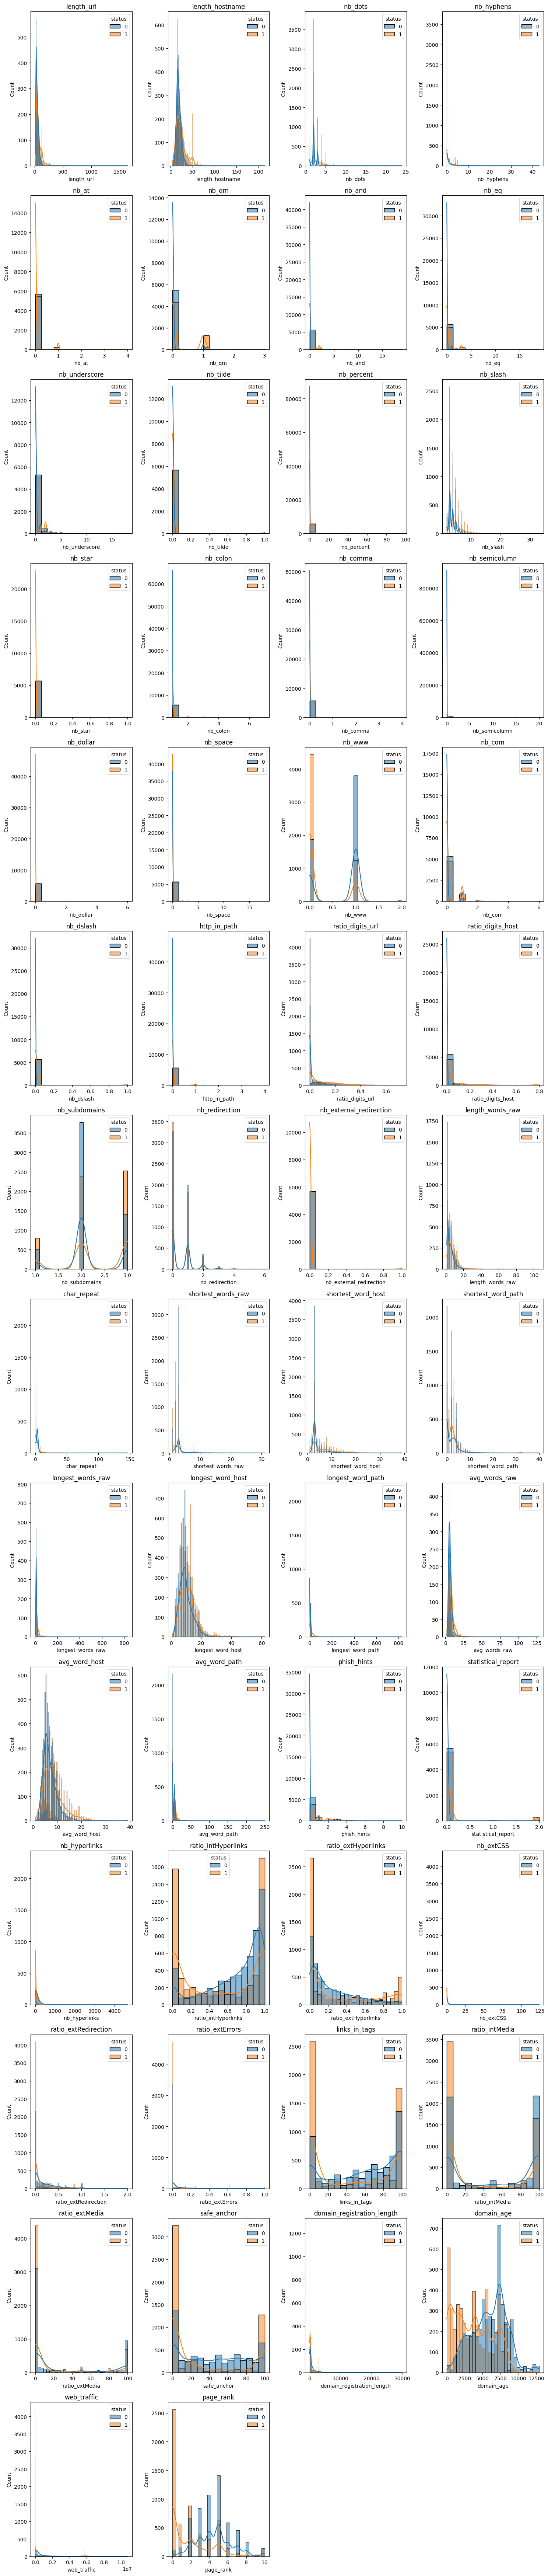

In [ ]:
num_plots_per_row = 4
num_rows = (len(numerical_cols) + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))

for i, feature in enumerate(numerical_cols):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.histplot(data=web, x=feature, hue='status', kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)

# Remove any unused subplots
for i in range(len(numerical_cols), num_rows * num_plots_per_row):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


### Deal with skewness by log scaling

By observing all the plots above and info summary below, we could see that some numerical features highly skewed, for example `length_url` which could possibly degrades the model's ability as it has to handle rare instances characterized by extreme values.

To handle the skewness of these features, a decision has been made to employ a log transformation technique. This transformation involves taking the logarithm of the values, which tends to compress larger values more than smaller ones. By doing so, the transformation helps in reducing the influence of extreme values and alleviating the impact of skewness.

Implementing the log transformation aims to create a more balanced distribution. This adjusted distribution can enhance the model's ability to effectively capture patterns and relationships within the data.

We implement log transformation on highly-skewed features, of which range is at least 100.

In [19]:
web.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,nb_extCSS,ratio_extRedirection,ratio_extErrors,login_form,external_favicon,links_in_tags,ratio_intMedia,ratio_extMedia,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,9586.00,11384.00,11384.00,11384.00,11384.00,11384.00
mean,61.18,21.11,0.15,2.48,1.00,0.02,0.14,0.16,0.29,0.32,0.01,0.12,4.29,0.00,1.03,0.00,0.06,0.00,0.03,0.45,0.13,0.01,0.02,0.61,0.05,0.03,0.00,0.00,0.07,0.05,0.02,2.23,0.20,0.08,0.12,0.00,0.50,0.00,6.24,2.93,3.13,5.02,2.40,15.40,10.48,10.57,7.26,7.68,5.09,0.33,0.10,0.00,0.00,0.02,0.06,87.15,0.60,0.28,0.79,0.16,0.06,0.06,0.44,51.97,42.85,23.26,0.00,0.01,37.08,0.00,0.00,0.12,0.78,0.44,0.07,494.53,4839.89,857421.21,0.02,0.53,3.19,0.50
std,55.37,10.79,0.36,1.37,2.09,0.16,0.36,0.82,1.00,1.10,0.08,1.47,1.88,0.03,0.24,0.10,0.60,0.08,0.38,0.50,0.38,0.08,0.17,0.49,0.09,0.09,0.02,0.05,0.25,0.22,0.15,0.64,0.40,0.28,0.33,0.01,0.69,0.06,5.58,4.78,2.22,3.95,2.98,22.12,4.94,23.11,4.15,3.58,7.15,0.84,0.31,0.06,0.07,0.13,0.33,166.61,0.38,0.32,2.76,0.27,0.16,0.24,0.50,41.53,46.25,38.41,0.04,0.08,39.10,0.03,0.04,0.33,0.42,0.50,0.26,815.81,2782.31,1996622.01,0.14,0.50,2.54,0.50
min,12.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,2.00,1.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,33.00,15.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,2.00,3.00,0.00,9.00,7.00,0.00,5.25,5.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,86.00,2428.25,0.00,0.00,0.00,1.00,0.00
50%,47.00,19.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,3.00,3.00,3.00,2.00,11.00,10.00,7.00,6.50,7.00,4.86,0.00,0.00,0.00,0.00,0.00,0.00,34.00,0.74,0.13,0.00,0.00,0.00,0.00,0.00,60.00,11.11,0.00,0.00,0.00,23.26,0.00,0.00,0.00,1.00,0.00,0.00,245.00,5075.00,1625.00,0.00,1.00,3.00,1.00
75%,71.00,24.0

For example, the distribution of `length_url` is highly skewed, with more than 87% of values smaller than 100, while the largest value is 1641.

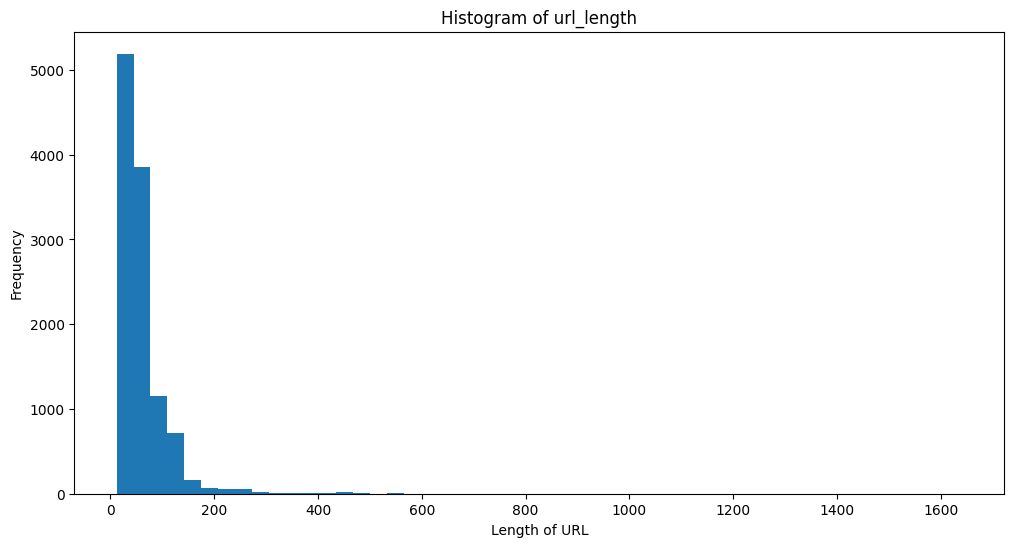

In [20]:
plt.figure(figsize=(12, 6))

plt.hist(web['length_url'], bins=50)
plt.xlabel('Length of URL')
plt.ylabel('Frequency')
plt.title('Histogram of url_length')
plt.show()

In this case, we perform log transformation.

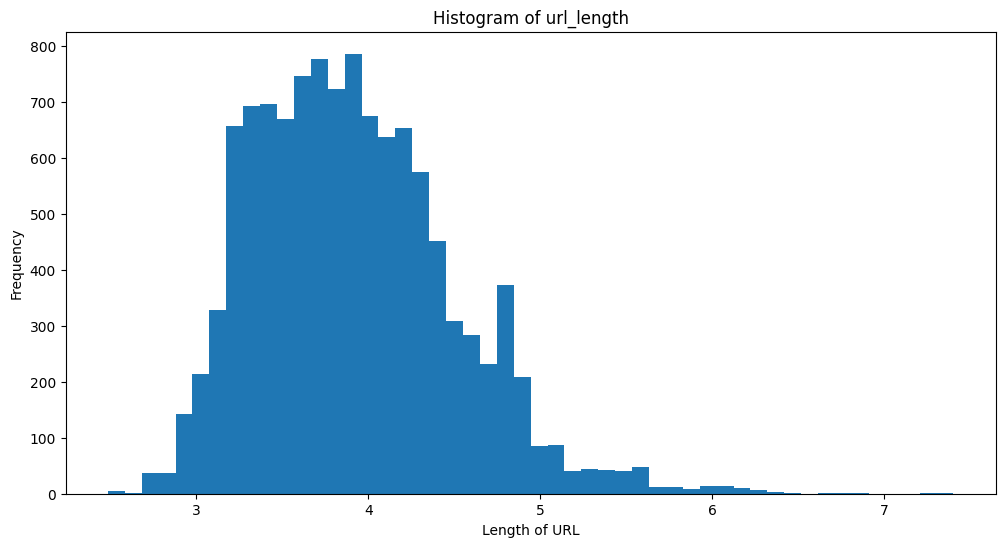

In [21]:
min_length = web['length_url'].min()
length_url_log = web['length_url'].apply(lambda x: np.log(x))

plt.figure(figsize=(12, 6))

plt.hist(length_url_log, bins=50)
plt.xlabel('Length of URL')
plt.ylabel('Frequency')
plt.title('Histogram of url_length')
plt.show()

In the following code, we perform log transformation on highly-skewed features, of which range is at least 100.

In [22]:
cols_to_log_transform = ['length_url', 'length_hostname', 'length_words_raw', 'char_repeat', 'longest_words_raw', 'longest_word_path', 'avg_words_raw',
              'avg_word_path', 'nb_hyperlinks', 'nb_extCSS', 'domain_registration_length', 'domain_age',  'web_traffic']

for col in cols_to_log_transform:
  web[col] = web[col].apply(lambda x: np.nan if pd.isnull(x) else np.log(x+1))


In [23]:
web.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,nb_extCSS,ratio_extRedirection,ratio_extErrors,login_form,external_favicon,links_in_tags,ratio_intMedia,ratio_extMedia,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,11384.00,9586.00,11384.00,11384.00,11384.00,11384.00,11384.00
mean,3.94,3.01,0.15,2.48,1.00,0.02,0.14,0.16,0.29,0.32,0.01,0.12,4.29,0.00,1.03,0.00,0.06,0.00,0.03,0.45,0.13,0.01,0.02,0.61,0.05,0.03,0.00,0.00,0.07,0.05,0.02,2.23,0.20,0.08,0.12,0.00,0.50,0.00,1.79,1.11,3.13,5.02,2.40,2.59,10.48,1.75,2.05,7.68,1.41,0.33,0.10,0.00,0.00,0.02,0.06,3.31,0.60,0.28,0.34,0.16,0.06,0.06,0.44,51.97,42.85,23.26,0.00,0.01,37.08,0.00,0.00,0.12,0.78,0.44,0.07,4.95,8.11,6.73,0.02,0.53,3.19,0.50
std,0.57,0.39,0.36,1.37,2.09,0.16,0.36,0.82,1.00,1.10,0.08,1.47,1.88,0.03,0.24,0.10,0.60,0.08,0.38,0.50,0.38,0.08,0.17,0.49,0.09,0.09,0.02,0.05,0.25,0.22,0.15,0.64,0.40,0.28,0.33,0.01,0.69,0.06,0.59,0.71,2.22,3.95,2.98,0.53,4.94,1.23,0.33,3.58,0.96,0.84,0.31,0.06,0.07,0.13,0.33,1.77,0.38,0.32,0.57,0.27,0.16,0.24,0.50,41.53,46.25,38.41,0.04,0.08,39.10,0.03,0.04,0.33,0.42,0.50,0.26,2.18,1.24,6.19,0.14,0.50,2.54,0.50
min,2.56,1.61,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.00,1.00,1.00,0.00,1.10,1.00,0.00,1.10,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.53,2.77,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.10,0.69,2.00,3.00,0.00,2.30,7.00,0.00,1.83,5.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.30,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,4.47,7.80,0.00,0.00,0.00,1.00,0.00
50%,3.87,3.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.79,1.39,3.00,3.00,2.00,2.48,10.00,2.08,2.01,7.00,1.77,0.00,0.00,0.00,0.00,0.00,0.00,3.56,0.74,0.13,0.00,0.00,0.00,0.00,0.00,60.00,11.11,0.00,0.00,0.00,23.26,0.00,0.00,0.00,1.00,0.00,0.00,5.51,8.53,7.39,0.00,1.00,3.00,1.00
75%,4.28,3.22,0.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5

### Handle collinearity and multicollinearity

Identifing collinearity and multicollinearity relationships between features:

- Collinearity refers to the situation in which two or more predictor variables are closely related to one another. It can pose problems in the regression context as it might be hard to separate out the individual effects of collinear variables. Moreover, Multicollinearity refers to the state where three or more the independent variables closely related to one another.

- Here, we decided to collinearity and multicollinearity by plotting heatmap and calculating the Variance Inflation Factor (VIF) of our dataset.

- First, we use a heatmep to visualize the correlation between features in the dataset. By calculating pearson's correlation coefficients between all pairs of features, a heatmap can the be generated. It helps us to identify easily from the chart and spot relationships between independent features by finding high correlation values (close to 1 or -1). We will identify correlation above 0.8.

- Next, we can calculate Variance Inflation Factor (VIF) to identify multicollinearity and decide which features to drop. For each feature, VIF quantifies how much the variance of that feature’s coefficient is inflated due to its relationship with other features.A VIF of 1 means no correlation. However, if a feature has a VIF value above 10, it indicates significant multicollinearity. At this point, it may be worth removing or adjusting the feature to reduce multicollinearity.

Reference:
[Targeting Multicollinearity With Python](https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b)

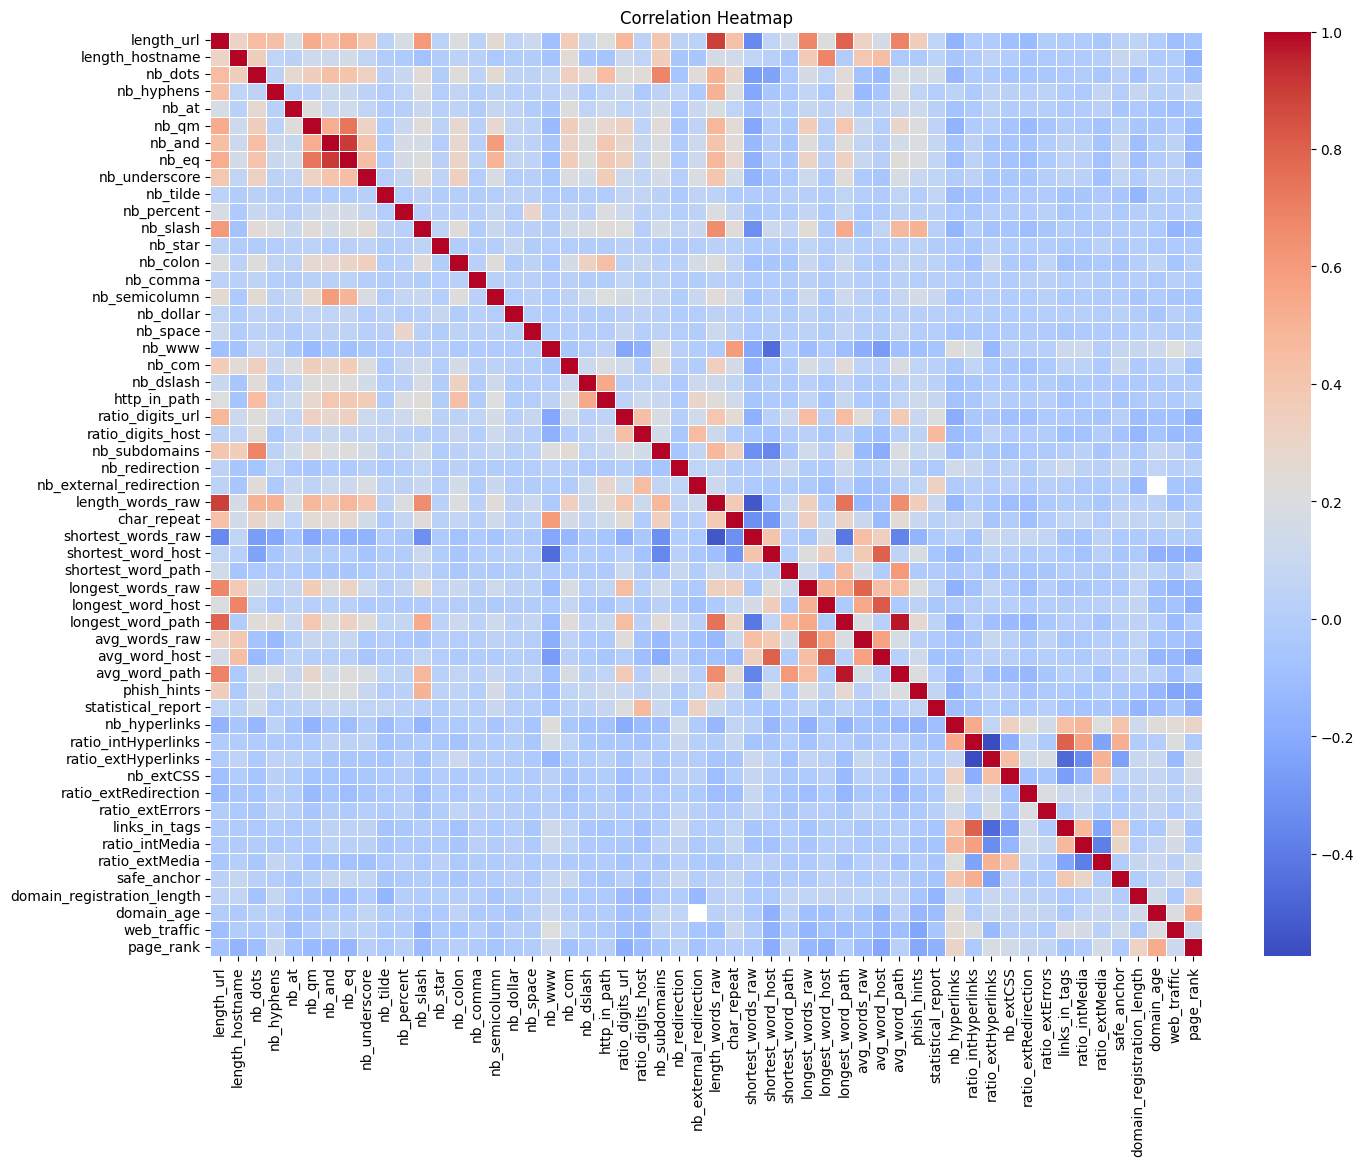

In [24]:
# Calculate the correlation matrix
correlation_matrix = web[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Calculate the correlation matrix and DataFrame from the correlatipon matrix
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Filter for pairs with absolute correlation greater than 0.8
high_correlation_pairs = correlation_pairs[(correlation_pairs['Correlation'].abs() > 0.8) & (correlation_pairs['Feature1'] != correlation_pairs['Feature2'])]

# Remove duplicate pairs
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs['Feature1'] < high_correlation_pairs['Feature2']]

# Sort the pairs by correlation in descending order
high_correlation_pairs_sorted = high_correlation_pairs.sort_values(by='Correlation', ascending=False)

# Print the result
print(high_correlation_pairs_sorted)

           Feature1            Feature2  Correlation
2032  avg_word_path   longest_word_path         0.97
331          nb_and               nb_eq         0.91
27       length_url    length_words_raw         0.89
1977  avg_word_host   longest_word_host         0.82
1974  avg_word_host  shortest_word_host         0.80


From the above result, we could see that there are highly-correlated features. However, it is difficult to decide on features to be dropped. In this case, we use VIF to find out these features. We choose 10 as our threshold according to the reference material. This means that we will drop features with high VIF value untill the highest VIF is smaller than 10.

In [26]:
def compute_vif(considered_features, data):
  X = data[considered_features].copy()
  X['intercept'] = 1
  X = X.dropna(axis=1)

  vif = pd.DataFrame()
  vif["Variable"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif = vif[vif['Variable'] != 'intercept']
  return vif

In [27]:
# Weights feature not part of dataset but for model training
considered_features = numerical_cols.copy()
compute_vif(considered_features, web).sort_values('VIF', ascending=False)[:10]

,Variable,VIF
0,length_url,114.50
34,longest_word_path,100.21
37,avg_word_path,81.57
27,length_words_raw,81.29
36,avg_word_host,46.27
35,avg_words_raw,34.20
30,shortest_word_host,18.90
33,longest_word_host,18.68
32,longest_words_raw,16.36
7,nb_eq,12.66


In [28]:
considered_features.remove('length_url')
compute_vif(considered_features, web).sort_values('VIF', ascending=False)[:10]

,Variable,VIF
33,longest_word_path,99.35
36,avg_word_path,81.45
35,avg_word_host,44.84
32,longest_word_host,18.54
29,shortest_word_host,18.38
26,length_words_raw,16.73
31,longest_words_raw,16.35
34,avg_words_raw,13.05
6,nb_eq,12.53
5,nb_and,9.65


In [29]:
considered_features.remove('longest_word_path')
compute_vif(considered_features, web).sort_values('VIF', ascending=False)[:10]

,Variable,VIF
34,avg_word_host,44.68
29,shortest_word_host,18.37
32,longest_word_host,17.90
26,length_words_raw,16.09
6,nb_eq,12.49
33,avg_words_raw,11.22
31,longest_words_raw,9.66
5,nb_and,9.64
35,avg_word_path,7.24
39,ratio_intHyperlinks,5.22


In [30]:
considered_features.remove('avg_word_host')
compute_vif(considered_features, web).sort_values('VIF', ascending=False)[:10]

,Variable,VIF
26,length_words_raw,16.09
6,nb_eq,12.47
33,avg_words_raw,10.92
31,longest_words_raw,9.56
5,nb_and,9.55
34,avg_word_path,7.23
38,ratio_intHyperlinks,5.22
0,length_hostname,3.92
37,nb_hyperlinks,3.89
1,nb_dots,3.66


In [31]:
considered_features.remove('length_words_raw')
compute_vif(considered_features, web).sort_values('VIF', ascending=False)[:10]

,Variable,VIF
6,nb_eq,12.46
5,nb_and,9.54
32,avg_words_raw,9.40
30,longest_words_raw,9.27
37,ratio_intHyperlinks,5.22
33,avg_word_path,4.41
36,nb_hyperlinks,3.89
1,nb_dots,3.63
0,length_hostname,3.57
31,longest_word_host,3.54


In [32]:
considered_features.remove('nb_eq')
compute_vif(considered_features, web).sort_values('VIF', ascending=False)[:10]

,Variable,VIF
31,avg_words_raw,9.37
29,longest_words_raw,9.23
36,ratio_intHyperlinks,5.20
32,avg_word_path,4.41
35,nb_hyperlinks,3.89
0,length_hostname,3.54
30,longest_word_host,3.53
1,nb_dots,3.51
26,shortest_words_raw,3.17
41,links_in_tags,3.03


In [33]:
cols_to_drop = ['length_url', 'longest_word_path', 'avg_word_host', 'length_words_raw', 'nb_eq']
web = web.drop(cols_to_drop, axis=1)

## Train-test split


In the following section, we choose a 70-15-15 ratio for splitting the dataset into training, validation, and test sets to balance the need for sufficient training data with the necessity of evaluating model performance effectively.
- The 70% training set allows the model to learn from a robust amount of data, helping it to generalize well to unseen data.
- The 15% validation set is crucial for tuning hyperparameters and preventing overfitting, providing timely feedback on the model’s performance during training.
- The 15% test set serves to evaluate the model’s final performance without bias, ensuring that the assessment is based on data the model has not encountered before.

Reference: [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)

In [34]:
X = web.drop('status', axis=1)
y = web['status']

# Split the dataset into Train, Validation and Test sets by ratio of 70:15:15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4266)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=4266)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (7968, 78)
X_val shape:  (1708, 78)
X_test shape:  (1708, 78)


## Feature Scaling

- We employ normalization to scale the data since there is no evident normal distribution patterns in our numerical features. Unlike standardization, which assumes a normal distribution in the data, normalization is chosen for its ability to scale features within a specific range without assuming any specific distribution pattern.
- Normalization scales the values of numerical features to a common range, preventing any particular feature from dominating due to its larger magnitude during model training.

In [35]:
scaler = MinMaxScaler()

# Use considered_features(instead of numerical_cols) as it excluded hihgly correlated features
columns_to_scale = considered_features.copy()

# Fit the scaler on the training data
scaler.fit(X_train[columns_to_scale])

# Transform the specified columns in both training and test DataFrames
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])

## Handle missing values

- For numerical data in `domain_age` column, we've opted to replace missing values with the mean value of the column. Imputing missing numerical values with the mean maintains the dataset's integrity by substituting NaN entries with a central tendency measure that doesn't significantly impact the column's overall distribution.
- We ensure that any imputation strategy we apply to our vaidation and test data are consistent with what we did for the training data to ensure cosistency while preventing data leakage.

In [36]:
X_train_without_missing = X_train.copy()
X_test_without_missing = X_test.copy()
X_val_without_missing = X_val.copy()

# Replace missing values in domain_age with mean value of the column
mean_value = X_train_without_missing['domain_age'].mean()
X_train_without_missing['domain_age'].fillna(mean_value, inplace=True)
X_test_without_missing['domain_age'].fillna(mean_value, inplace=True)
X_val_without_missing['domain_age'].fillna(mean_value, inplace=True)

In [37]:
X_train_without_missing['domain_age'].info()

<class 'pandas.core.series.Series'>
Index: 7968 entries, 5335 to 10365
Series name: domain_age
Non-Null Count  Dtype  
--------------  -----  
7968 non-null   float64
dtypes: float64(1)
memory usage: 124.5 KB


In [38]:
X_test_without_missing['domain_age'].info()

<class 'pandas.core.series.Series'>
Index: 1708 entries, 8732 to 4424
Series name: domain_age
Non-Null Count  Dtype  
--------------  -----  
1708 non-null   float64
dtypes: float64(1)
memory usage: 26.7 KB


In [39]:
X_val_without_missing['domain_age'].info()

<class 'pandas.core.series.Series'>
Index: 1708 entries, 2979 to 3119
Series name: domain_age
Non-Null Count  Dtype  
--------------  -----  
1708 non-null   float64
dtypes: float64(1)
memory usage: 26.7 KB


## Feature Selection using ANOVA

SelectKBest method was selected for efficient feature selection. Specifically, the ANOVA F-test scoring function was chosen because it can evaluate and rank features based on their statistical relationship with the target variable. This approach is crucial in reducing the number of features while still retaining the most informative ones, ultimately improving model performance and reducing the risk of overfitting.

The F-score of each feature reflects the strength of the linear relationship between that feature and the target variable. In this study, the top 30 features with the highest F-scores were selected, which indicates the high significance for model training. This same feature subset would be applied to the training, validation and test datasets to ensure consistency in model evaluation and performance analysis.

[Reference: Optimizing Performance: SelectKBest for Efficient Feature Selection in Machine Learning](https://medium.com/@Kavya2099/optimizing-performance-selectkbest-for-efficient-feature-selection-in-machine-learning-3b635905ed48#a64d)

In [40]:
X = X_train_without_missing.copy()
# Drop url text column
X = X.drop(['url', 'words_raw'], axis=1)
y = y_train.copy()

# Perform ANOVA F-test for feature selection on training set
selector = SelectKBest(score_func=f_classif, k=30)
X_selected = selector.fit_transform(X, y)
mask = selector.get_support() # Get the mask of selected features
train_set_selected_features = X.columns[mask]
print("Selected features using ANOVA for train set:", train_set_selected_features.tolist())

# Get the F-scores of each feature
f_scores = selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'F Score': f_scores})
feature_scores_sorted = feature_scores.sort_values(by='F Score', ascending=False)
print(feature_scores_sorted)

Selected features using ANOVA for train set: ['length_hostname', 'ip', 'nb_dots', 'nb_qm', 'nb_and', 'nb_slash', 'nb_www', 'nb_com', 'ratio_digits_url', 'ratio_digits_host', 'tld_in_subdomain', 'prefix_suffix', 'shortest_word_host', 'longest_words_raw', 'avg_words_raw', 'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks', 'links_in_tags', 'ratio_intMedia', 'safe_anchor', 'empty_title', 'domain_in_title', 'domain_with_copyright', 'domain_registration_length', 'domain_age', 'web_traffic', 'google_index', 'page_rank']
                       Feature  F Score
74                google_index  8896.89
75                   page_rank  2720.08
50               nb_hyperlinks  2676.42
17                      nb_www  2167.42
72                 web_traffic  1159.82
22            ratio_digits_url  1127.37
71                  domain_age  1072.46
67             domain_in_title  1029.18
44                 phish_hints   985.70
1                           ip   890.56
40           longest

In [41]:
selected_feature_ANOVA = train_set_selected_features.tolist()
selected_feature_ANOVA.append('url')
selected_feature_ANOVA.append('words_raw')
X_train_ANOVA = X_train_without_missing[selected_feature_ANOVA]
X_val_ANOVA = X_val_without_missing[selected_feature_ANOVA]
X_test_ANOVA = X_test_without_missing[selected_feature_ANOVA]

In [42]:
print(f'Shape of X_train_ANOVA: {X_train_ANOVA.shape}')
print(f'Shape of X_val_ANOVA: {X_val_ANOVA.shape}')
print(f'Shape of X_test_ANOVA: {X_test_ANOVA.shape}')

Shape of X_train_ANOVA: (7968, 32)
Shape of X_val_ANOVA: (1708, 32)
Shape of X_test_ANOVA: (1708, 32)


## Word embedding

To utilize words information extracted from url text (`words_raw`), we can treat the words information as a sentence. There is a kind of sequential information as it is formed by words extracted from domain, path, and subdomain in sequence.

We decided to employ [FastText](https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText) model, which allows training word embeddings from a training corpus with the additional ability to obtain word vectors for out-of-vocabulary words.

We first create our 'sentence dataset' by combining the `words_raw` column of `X_train_without_missing`, `X_val_without_missing`, `X_test_without_missing`, then use it to build vocabulary and train the embedding model.

Then we use the trained model to generated words embeddings for words information of each url.

Since the words information are of different length for different url, we use `pad_sentence()` function from TensorFlow to add paddinsg to ensure that the embeddings for each url are of the same length (maximum length of words information of all urls)

In [43]:
# combining the words_raw column of X_train_without_missing, X_val_without_missing, X_test_without_missing
words_raw_list = X_train_without_missing['words_raw'].tolist() + \
                 X_val_without_missing['words_raw'].tolist() + \
                 X_test_without_missing['words_raw'].tolist()
len(words_raw_list)

11384

In [44]:
# Train FastText embedding model

model = FastText(vector_size=4, window=3, min_count=1)
model.build_vocab(corpus_iterable=words_raw_list)
model.train(corpus_iterable=words_raw_list, total_examples=len(words_raw_list), epochs=10)  # train

(614999, 710150)

In [45]:
# Generate word embedding for words_raw of each url

def words_to_embeddings(words_list, model):
    # Convert each word in the list to its FastText embedding
    return [model.wv[word] if word in model.wv else np.zeros(model.vector_size) for word in words_list]

In [46]:
words_raw_embeddings_train = [words_to_embeddings(words, model) for words in X_train_without_missing['words_raw'].tolist()]
words_raw_embeddings_val = [words_to_embeddings(words, model) for words in X_val_without_missing['words_raw'].tolist()]
words_raw_embeddings_test = [words_to_embeddings(words, model) for words in X_test_without_missing['words_raw'].tolist()]

In [47]:
# Find out length of longest words_raw

max_length = max(len(words) for words in words_raw_list)
max_length

106

In [48]:
# Add paddings to embeddings to ensure fixed input length
padded_embeddings_train = pad_sequences(words_raw_embeddings_train, maxlen=max_length, padding='pre', dtype='float32')
padded_embeddings_val = pad_sequences(words_raw_embeddings_val, maxlen=max_length, padding='pre', dtype='float32')
padded_embeddings_test = pad_sequences(words_raw_embeddings_test, maxlen=max_length, padding='pre', dtype='float32')

print("Padded training embedding sequences shape:", padded_embeddings_train.shape)
print("Padded validation embedding sequences shape:", padded_embeddings_val.shape)
print("Padded test embedding sequences shape:", padded_embeddings_test.shape)

Padded training embedding sequences shape: (7968, 106, 4)
Padded validation embedding sequences shape: (1708, 106, 4)
Padded test embedding sequences shape: (1708, 106, 4)


### Concatenating the padded embeddings to our `without_missing` dataframe

In [49]:
# since 3d, we must first flatten the padded embeddings to 2d so that we can fit it back to the df features
num_samples, max_length, embedding_dim = padded_embeddings_train.shape
flattened_embeddings_train = padded_embeddings_train.reshape(num_samples, max_length * embedding_dim)
print(flattened_embeddings_train.shape)
X_train_without_missing_copy = X_train_without_missing.copy()
X_train_without_missing_copy.reset_index(drop=True, inplace=True)

# convert the 2d flattened padded embeddings to a dataframe and concat it with the original df
embedding_df_train = pd.DataFrame(flattened_embeddings_train)
X_train_with_embeddings = pd.concat([X_train_without_missing_copy, embedding_df_train], axis=1)

print("New DataFrame shape:", X_train_with_embeddings.shape)

(7968, 424)
New DataFrame shape: (7968, 502)


In [50]:
# since 3d, we must first flatten the padded embeddings to 2d so that we can fit it back to the df features
num_samples, max_length, embedding_dim = padded_embeddings_val.shape
flattened_embeddings_val = padded_embeddings_val.reshape(num_samples, max_length * embedding_dim)
print(flattened_embeddings_val.shape)
X_val_without_missing_copy = X_val_without_missing.copy()
X_val_without_missing_copy.reset_index(drop=True, inplace=True)

# convert the 2d flattened padded embeddings to a dataframe and concat it with the original df
embedding_df_val = pd.DataFrame(flattened_embeddings_val)
X_val_with_embeddings = pd.concat([X_val_without_missing_copy, embedding_df_val], axis=1)

print("New DataFrame shape:", X_val_with_embeddings.shape)

(1708, 424)
New DataFrame shape: (1708, 502)


In [51]:
# since 3d, we must first flatten the padded embeddings to 2d so that we can fit it back to the df features
num_samples, max_length, embedding_dim = padded_embeddings_test.shape
flattened_embeddings_test = padded_embeddings_test.reshape(num_samples, max_length * embedding_dim)
print(flattened_embeddings_test.shape)
X_test_without_missing_copy = X_test_without_missing.copy()
X_test_without_missing_copy.reset_index(drop=True, inplace=True)

# convert the 2d flattened padded embeddings to a dataframe and concat it with the original df
embedding_df_test = pd.DataFrame(flattened_embeddings_test)
X_test_with_embeddings = pd.concat([X_test_without_missing_copy, embedding_df_test], axis=1)

print("New DataFrame shape:", X_test_with_embeddings.shape)

(1708, 424)
New DataFrame shape: (1708, 502)


## Autoencoder

With 76 features in `without_missing` dataset and 500 features in flattened word embeddings dataset, aka `embedding`(excluding `url` and `words_raw`), our dataset's high dimensionality may cause overfitting and high computational cost. We used an Autoencoder to reduce feature space, retaining only the most informative aspects.

An Autoencoder has three main parts: an encoder that compresses input data, a bottleneck layer containing the compressed representation, and a decoder that reconstructs the input from this representation. We use the compact bottleneck representation to simplify the dataset

### Autoencoder for `without_missing` dataset

We first construct a small autoencoder with only 1 encoder layer and 1 decoder layer to have a sense of how autoencoder works.
- For the hidden layers, we use ReLu as activation to prevernt vanishing gradient problem as autoencoder is also trained through backpropagation.
- For the output layer of decoder, we use sigmoid as activation as our input dataset has been normalized with range (0,1).

[Reference](https://devshahs.medium.com/build-an-autoencoder-with-me-b784cabd7e70#:~:text=Output%20Layer%3A%20The%20final%20layer,sigmoid%20for%20normalized%20pixel%20values)

In [53]:
X_train = X_train_without_missing.copy().drop(['url', 'words_raw'], axis=1)
X_val = X_val_without_missing.copy().drop(['url', 'words_raw'], axis=1)
X_test = X_test_without_missing.copy().drop(['url', 'words_raw'], axis=1)
# Drop url text column
input_dim = X_train.shape[1]

# Define input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)      # Bottleneck layer

# Decoder
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Use sigmoid for normalized data

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model
encoder = Model(inputs=input_layer, outputs=encoded)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = autoencoder.fit(X_train, X_train,
              epochs=20,
              batch_size=256,
              shuffle=True,
              validation_data=(X_val, X_val))

# Implement the model on the test set
test_loss = autoencoder.evaluate(X_test, X_test)
print(f'Test Loss: {test_loss}')

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2022 - val_loss: 0.1504
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1198 - val_loss: 0.0579
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540 - val_loss: 0.0507
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 - val_loss: 0.0470
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.0419
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0402 - val_loss: 0.0375
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360 - val_loss: 0.0344
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334 - val_loss: 0.0319
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - val_loss: 0.0300
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294 - val_loss: 0.0285
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - val_loss: 0.0271
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_lo

### Autoencoder tuning
The simple autoencoder give us validation loss of 0.0192. To further improve the loss, we defined a function named `build_model`, which could build model with different number of hidden layers for encoder and decoder, as well as different number of neurons in each layer. With the help of RandomSearch, we could potentially find better combination of number of layers and neurons for our autoencoder.

Since our `X_train_without_missing`, `X_val_without_missing`, and `X_test_without_missing` have 76 numerical and categorical features, the input dimension is 76. In this case, we decided to utilize the autoencoder to compress it down to a 16-dimensional latent space representation in the bottleneck layer. Then we could extract the encoder part of the autoencoder to reduces the dimensionality of our input features, capturing the most important aspects of the data. These compressed features can then be used as input for our variours classification models.

Here we do random search for 100 times. We also tried more trials but it appearst that the loss result ontained from 1000 trials is not improved significantly as compared to the loss obtained from 100 trials.

Reference:
- [Autoencoder Feature Extraction for Classification](https://machinelearningmastery.com/autoencoder-for-classification/)
- [Keras RandomSearch Tuner](https://keras.io/api/keras_tuner/tuners/random/)
- [Tuning Model Hyperparameters With Random Search](https://medium.com/@hammad.ai/tuning-model-hyperparameters-with-random-search-f4c1cc88f528)

In [53]:
def build_model(hp):
    input_layer = Input(shape=(input_dim,))

    # Tuning number of neurons
    for i in range(hp.Int('num_layers', 1, 10)):  # Tuning the number of layers
        if i == 0:
            encoded = Dense(hp.Int('units_' + str(i), 32, 64, step=8), activation='relu')(input_layer)
        else:
            encoded = Dense(hp.Int('units_' + str(i), 32, 64, step=8), activation='relu')(encoded)

    # Bottleneck
    bottleneck = Dense(16, activation='relu')(encoded)

    # Decoder
    for i in range(hp.Int('num_layers', 1, 10)):
        decoded = Dense(hp.Int('units_' + str(i), 32, 64, step=8), activation='relu')(bottleneck)

    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    model = Model(inputs=input_layer, outputs=decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner1 = RandomSearch(build_model,
            objective='val_loss',
            max_trials=100,
            executions_per_trial=3,
            directory='my_dir',
            project_name='autoencoder_without_missing'
            )

# Start the tuning process
tuner1.search(X_train, X_train, epochs=20, validation_data=(X_val, X_val))

# Retrieve the best model
best_model_1 = tuner1.get_best_models(num_models=1)[0]

Trial 100 Complete [00h 00m 45s]
val_loss: 0.005423552977542083

Best val_loss So Far: 0.005423552977542083
Total elapsed time: 01h 15m 53s


In [54]:
best_model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 76)             │         4,940 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,996 (46.86 KB)

 Trainable params: 11,996 (46.86 KB)

 Non-trainable params: 0 (0.00 B)

Then we extract the encoder part from the autoencoder.

In [55]:
# Use `best_model.layers` to extract the encoder part.
bottleneck_layer_index = [layer.name for layer in best_model_1.layers].index('dense_1')  # replace 'dense_x' with your bottleneck layer name

# Create the encoder model
encoder_model = Model(inputs=best_model_1.input, outputs=best_model_1.layers[bottleneck_layer_index].output)

# Get the latent features (encoded representations) from the encoder model
X_train_encoded = encoder_model.predict(X_train)
X_val_endoced = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test)

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [56]:
X_train_encoded.shape

(7968, 16)

In [60]:
scaler = MinMaxScaler()

scaler.fit(X_train_encoded)

# Transform the specified columns in both training and test DataFrames
X_train_encoded = scaler.transform(X_train_encoded)
X_val_endoced = scaler.transform(X_val_endoced)
X_test_encoded = scaler.transform(X_test_encoded)

In [61]:
X_train_encoded = pd.DataFrame(X_train_encoded)
X_val_endoced = pd.DataFrame(X_val_endoced)
X_test_encoded = pd.DataFrame(X_test_encoded)

## Autoencoder for `embedding` dataset
In this section, we train another autoencoder for the dataset with url words embedding information.

In [55]:
X_train_embedded = X_train_with_embeddings.copy().drop(['url', 'words_raw'], axis=1)
X_val_embedded = X_val_with_embeddings.copy().drop(['url', 'words_raw'], axis=1)
X_test_embedded = X_test_with_embeddings.copy().drop(['url', 'words_raw'], axis=1)
# Drop url text column
input_dim = X_train_embedded.shape[1]


# Define input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)      # Bottleneck layer

# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Use sigmoid for normalized data

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model
encoder = Model(inputs=input_layer, outputs=encoded)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = autoencoder.fit(X_train_embedded, X_train_embedded,
              epochs=20,
              batch_size=256,
              shuffle=True,
              validation_data=(X_val_embedded, X_val_embedded))

# Implement the model on the test set
test_loss = autoencoder.evaluate(X_test_embedded, X_test_embedded)
print(f'Test Loss: {test_loss}')

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.7105 - val_loss: 0.5900
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5350 - val_loss: 0.5781
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5230 - val_loss: 0.5750
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5292 - val_loss: 0.5740
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5267 - val_loss: 0.5728
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5247 - val_loss: 0.5713
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5193 - val_loss: 0.5705
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5164 - val_loss: 0.5696
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5166 - val_loss: 0.5689
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5222 - val_loss: 0.5678
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5209 - val_loss: 0.5666
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5112 - va

### Autoencoder tunning

In [57]:
def build_model_embeddings(hp):
    input_layer = Input(shape=(input_dim,))

    # Tuning number of neurons
    for i in range(hp.Int('num_layers', 1, 10)):  # Tuning the number of layers
        if i == 0:
            encoded = Dense(hp.Int('units_' + str(i), 64, 496, step=16), activation='relu')(input_layer)
        else:
            encoded = Dense(hp.Int('units_' + str(i), 64, 496, step=16), activation='relu')(encoded)

    # Bottleneck
    bottleneck = Dense(32, activation='relu')(encoded)

    # Decoder
    for i in range(hp.Int('num_layers', 1, 10)):
        decoded = Dense(hp.Int('units_' + str(i), 64, 496, step=16), activation='relu')(bottleneck)

    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    model = Model(inputs=input_layer, outputs=decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner2 = RandomSearch(build_model_embeddings,
            objective='val_loss',
            max_trials=100,
            executions_per_trial=3,
            directory='my_dir',
            project_name='autoencoder__embedding'
            )

# Start the tuning process
tuner2.search(X_train_embedded, X_train_embedded, epochs=20, validation_data=(X_val_embedded, X_val_embedded))

# Retrieve the best model
best_model_2 = tuner2.get_best_models(num_models=1)[0]

Trial 100 Complete [00h 02m 35s]
val_loss: 0.5980371634165446

Best val_loss So Far: 0.5478688279787699
Total elapsed time: 04h 26m 44s


In [58]:
best_model_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 208)            │       104,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         6,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 208)            │         6,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │       104,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,260 (868.20 KB)

 Trainable params: 222,260 (868.20 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Use `best_model.layers` to extract the encoder part.
bottleneck_layer_index = [layer.name for layer in best_model_2.layers].index('dense_1')  # replace 'dense_x' with your bottleneck layer name

# Create the encoder model
encoder_model_embeddings = Model(inputs=best_model_2.input, outputs=best_model_2.layers[bottleneck_layer_index].output)

# Get the latent features (encoded representations) from the encoder model
X_train_embeddings_encoded = encoder_model_embeddings.predict(X_train_embedded)
X_val_embeddings_encoded = encoder_model_embeddings.predict(X_val_embedded)
X_test_embeddings_encoded = encoder_model_embeddings.predict(X_test_embedded)

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [60]:
scaler = MinMaxScaler()

scaler.fit(X_train_embeddings_encoded)

# Transform the specified columns in both training and test DataFrames
X_train_embeddings_encoded = scaler.transform(X_train_embeddings_encoded)
X_test_embeddings_encoded = scaler.transform(X_test_embeddings_encoded)
X_val_embeddings_encoded = scaler.transform(X_val_embeddings_encoded)

In [61]:
print(X_train_embeddings_encoded.shape)

(7968, 32)


In [62]:
X_train_embeddings_encoded = pd.DataFrame(X_train_embeddings_encoded)
X_test_embeddings_encoded = pd.DataFrame(X_test_embeddings_encoded)
X_val_embeddings_encoded = pd.DataFrame(X_val_embeddings_encoded)

## Autoencoder with CNN for feature extraction

* Attempted autoencoder with CNN for feature extraction, but performance was poor, as the construction-reconstruction loss on the validation data was approximately 0.62 with a simple autoencoder.
* Conv1D was used for our autoencoder with CNN to capture patterns within word sequences.
* This loss was much higher than what was obtained in the other autoencoder built.
* With the better-performing encoder constructed (simpler model), we tried text classification as we were interested to know whether the dense representation of the padded embeddings dataset were good in detecting phishing websites.
* Using F1 Score as our example evaluation metric, we obtained a score of approximately 0.87 on the validation data.
* Since our primary models are already performing better with the raw numerical and categorical features, we decided not to utilise this as part of our training features for model simplicity and interpretability with fewer features.

### Autoencoder Construction-Reconstruction

#### Simpler Model
Without Batch Normalization, Dropout Regularization and Additional Callbacks

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D

# modify pre-padding to max length of 108 for autoencoder model to work later (prevent pooling and upsampling issues mismatch issues later)
padded_embeddings_train_cnn = pad_sequences(words_raw_embeddings_train, maxlen=max_length+2, padding='pre', dtype='float32')
padded_embeddings_val_cnn = pad_sequences(words_raw_embeddings_val, maxlen=max_length+2, padding='pre', dtype='float32')
padded_embeddings_test_cnn = pad_sequences(words_raw_embeddings_test, maxlen=max_length+2, padding='pre', dtype='float32')

input_shape = (max_length+2, 4)  # (108, 4) if max_length=106
input_seq = Input(shape=input_shape)
print(input_seq.shape)

# Encoder
encoded = Conv1D(32, 3, activation='relu', padding='same')(input_seq) # 32 filters to learn feature patterns with kernel size 3 for sliding across every 3 word vectors
print(encoded.shape)
encoded = MaxPooling1D(2, padding='same')(encoded) # max pooling to reduce to half the number of words (108 to 54)
print(encoded.shape)
encoded = Conv1D(16, 3, activation='relu', padding='same')(encoded) # learn finer or more specific featues after reduction in maxpooling
print(encoded.shape)
encoded = MaxPooling1D(2, padding='same')(encoded) # max pooling to further reduce number of words
print(encoded.shape)

# Decoder: mirrors encoder to reconstruct features
decoded = Conv1D(16, 3, activation='relu', padding='same')(encoded)
print(decoded.shape)
decoded = UpSampling1D(2)(decoded)
print(decoded.shape)
decoded = Conv1D(32, 3, activation='relu', padding='same')(decoded)
print(decoded.shape)
decoded = UpSampling1D(2)(decoded)
print(decoded.shape)
decoded = Conv1D(4, 3, activation='sigmoid', padding='same')(decoded)
print(decoded.shape)

# Autoencoder model
autoencoder = Model(inputs=input_seq, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(padded_embeddings_train_cnn, padded_embeddings_train_cnn,
              epochs=50,
              batch_size=64,
              shuffle=True,
              validation_split=0.2)


# Evaluate the model on the validation test set
validation_loss = autoencoder.evaluate(padded_embeddings_val_cnn, padded_embeddings_val_cnn)
print(f'Validation Test Loss: {validation_loss}')


# Create a model to extract features from the encoder
encoder = Model(input_seq, encoded)

# Get the encoded representations for the training set
encoded_train = encoder.predict(padded_embeddings_train_cnn)

# The encoded_train now contains the extracted features
print("Extracted Features Shape:", encoded_train.shape)

(None, 108, 4)
(None, 108, 32)
(None, 54, 32)
(None, 54, 16)
(None, 27, 16)
(None, 27, 16)
(None, 54, 16)
(None, 54, 32)
(None, 108, 32)
(None, 108, 4)
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.8667 - val_loss: 0.6073
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.5848 - val_loss: 0.5953
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.5920 - val_loss: 0.5942
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5757 - val_loss: 0.5938
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.5722 - val_loss: 0.5934
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.5917 - val_loss: 0.5931
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.5847 - val_loss: 0.5930
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5691 - val_loss: 0.5929
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5834 - val_loss: 0.5928
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.5

In [ ]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 108, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 108, 32)             │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 54, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 27, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 27, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 54, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 54, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_1 (UpSampling1D)       │ (None, 108, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 108, 4)              │             388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,126 (55.18 KB)

 Trainable params: 4,708 (18.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,418 (36.79 KB)

#### Complex Model
* Batch Normalization, Dropout Regularization and Additional Callbacks implemented
* Not much improvement from simpler model even with additional layers and parameters, instead validation loss higher than simpler model
* Indicates that reconstruction loss for this model higher than previous

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# modify pre-padding to max length of 108 for autoencoder model to work later (prevent pooling and upsampling issues mismatch issues later)
padded_embeddings_train_cnn = pad_sequences(words_raw_embeddings_train, maxlen=max_length+2, padding='pre', dtype='float32')
padded_embeddings_val_cnn = pad_sequences(words_raw_embeddings_val, maxlen=max_length+2, padding='pre', dtype='float32')
padded_embeddings_test_cnn = pad_sequences(words_raw_embeddings_test, maxlen=max_length+2, padding='pre', dtype='float32')

# Define model
input_shape = (max_length + 2, 4)  # 108 max length
input_seq = Input(shape=input_shape)

# Encoder
encoded = Conv1D(32, 3, activation='relu', padding='same')(input_seq) # 32 filters to learn feature patterns with kernel size 3 for sliding across every 3 word vectors
encoded = BatchNormalization()(encoded)  # batch normalization
encoded = Dropout(0.3)(encoded)          # dropout reg of 0.3
encoded = MaxPooling1D(2, padding='same')(encoded) # max pooling to further reduce number of words

encoded = Conv1D(16, 3, activation='relu', padding='same')(encoded) # learn finer or more specific featues after reduction in maxpooling
encoded = BatchNormalization()(encoded)  # batch normalization
encoded = Dropout(0.3)(encoded)          # dropout reg of 0.3
encoded = MaxPooling1D(2, padding='same')(encoded) # max pooling to further reduce number of words

# Decoder: mirrors encoder
decoded = Conv1D(16, 3, activation='relu', padding='same')(encoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(32, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(4, 3, activation='sigmoid', padding='same')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_seq, outputs=decoded)

# Define the optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # adjust learning rate here
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # early stopping to prevent overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the autoencoder with additional callbacks
autoencoder.fit(padded_embeddings_train_cnn, padded_embeddings_train_cnn,
                epochs=100,  # adjust number of epochs to train more
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the validation test set
validation_loss = autoencoder.evaluate(padded_embeddings_val_cnn, padded_embeddings_val_cnn)
print(f'Validation Test Loss: {validation_loss}')


# Create a model to extract features from the encoder
encoder = Model(input_seq, encoded)

# Get the encoded representations for the training set
encoded_train = encoder.predict(padded_embeddings_train_cnn)

# The encoded_train now contains the extracted features
print("Extracted Features Shape:", encoded_train.shape)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - loss: 0.8608 - val_loss: 0.8302 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.7284 - val_loss: 0.6633 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.5980 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.5878 - val_loss: 0.6020 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.5849 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.5742 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.5641 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.5755 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.5856 - val_loss: 0.5963 - learning_rate: 0.0010
Epoc

In [ ]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 108, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 108, 32)             │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 108, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 108, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 54, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 27, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 27, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_2 (UpSampling1D)       │ (None, 54, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 54, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_3 (UpSampling1D)       │ (None, 108, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 108, 4)              │             388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,510 (56.68 KB)

 Trainable params: 4,804 (18.77 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 9,610 (37.54 KB)

### Autoencoder Feature Extraction for Binary Phishing Classification
* With the simpler CNN autoencoder from the previous section, we tried to predict the binary labels phishing (1) and legitimate (0) with the compressed feature representations.
* Addition of Dense Layer and Dropout Regularisation improved F1 Score on validation data by a very small margin of 0.006.

#### Without Dense Layer

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Modify pre-padding to max length of 108 for text classification
padded_embeddings_train_cnn = pad_sequences(words_raw_embeddings_train, maxlen=max_length + 2, padding='pre', dtype='float32')
padded_embeddings_val_cnn = pad_sequences(words_raw_embeddings_val, maxlen=max_length + 2, padding='pre', dtype='float32')
padded_embeddings_test_cnn = pad_sequences(words_raw_embeddings_test, maxlen=max_length + 2, padding='pre', dtype='float32')

# Define model
input_shape = (max_length + 2, 4)  # 108 max length
input_seq = Input(shape=input_shape)

# Encoder
encoded = Conv1D(32, 3, activation='relu', padding='same')(input_seq)
encoded = MaxPooling1D(2, padding='same')(encoded)

encoded = Conv1D(16, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)

# Flatten the output for classification
flattened = Flatten()(encoded)  # flatten the features for the dense layer

# Classification Layer
output = Dense(1, activation='sigmoid')(flattened)  # output layer for binary classification

# Model for classification
classifier1 = Model(inputs=input_seq, outputs=output)

## Define f1-score since not available in tensorflow
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_pred = K.round(y_pred)  # Round y_pred to 0 or 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)  # True positives
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float32'), axis=0)  # True negatives
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)  # False positives
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)  # False negatives

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)


# Define the optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # adjust learning rate here
# classifier1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
classifier1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score]) # binary crossentropy for phishing classification

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the classifier
classifier1.fit(padded_embeddings_train_cnn, y_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stopping, reduce_lr])  # callbacks

# Evaluate the model on the validation test set
test_loss, test_accuracy, test_f1_score = classifier1.evaluate(padded_embeddings_val_cnn, y_val)
print("Validation Test Loss:", test_loss)
print("Validation Test Accuracy:", test_accuracy)
print("Validation Test F1-Score:", test_f1_score)

# Get predictions
predictions = classifier1.predict(padded_embeddings_val_cnn)
predicted_classes = (predictions > 0.5).astype(int)  # convert probabilities to binary predictions
print("Predicted Classes:", predicted_classes)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5774 - f1_score: 0.5071 - loss: 0.6585 - val_accuracy: 0.6926 - val_f1_score: 0.7060 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7201 - f1_score: 0.7213 - loss: 0.5826 - val_accuracy: 0.7729 - val_f1_score: 0.7556 - val_loss: 0.5311 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7885 - f1_score: 0.7851 - loss: 0.5041 - val_accuracy: 0.7886 - val_f1_score: 0.7622 - val_loss: 0.4743 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8022 - f1_score: 0.7937 - loss: 0.4540 - val_accuracy: 0.8011 - val_f1_score: 0.7818 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8114 - f1_score: 0.8101 - loss: 0.4310 - val_accuracy: 0.8206 - val_f1_score: 0.8170 - val_loss: 0.4206 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━

In [ ]:
classifier1.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 108, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 108, 32)             │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 54, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 27, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 432)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             433 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,205 (28.15 KB)

 Trainable params: 2,401 (9.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,804 (18.77 KB)

#### Added Dense Layer and Dropout Regularisation after Flattening
> Adding Dense Layer of size 64 and dropout regularisation of 0.5 performed slightly better than previous section.

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Modify pre-padding to max length of 108 for text classification
padded_embeddings_train_cnn = pad_sequences(words_raw_embeddings_train, maxlen=max_length + 2, padding='pre', dtype='float32')
padded_embeddings_val_cnn = pad_sequences(words_raw_embeddings_val, maxlen=max_length + 2, padding='pre', dtype='float32')
padded_embeddings_test_cnn = pad_sequences(words_raw_embeddings_test, maxlen=max_length + 2, padding='pre', dtype='float32')

# Define model
input_shape = (max_length + 2, 4)  # 108 max length
input_seq = Input(shape=input_shape)

# Encoder
encoded = Conv1D(32, 3, activation='relu', padding='same')(input_seq)
encoded = MaxPooling1D(2, padding='same')(encoded)

encoded = Conv1D(16, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)

# Flatten the output for classification
flattened = Flatten()(encoded)  # flatten the features for the dense layer

# Add Dense layer to learn more complex patterns
dense_output = Dense(64, activation='relu')(flattened)  # Adding a Dense layer
dense_output = Dropout(0.5)(dense_output)  # Optional dropout for regularization

# Classification Layer
output = Dense(1, activation='sigmoid')(dense_output)  # output layer for binary classification

# Model for classification
classifier2 = Model(inputs=input_seq, outputs=output)

## Define f1-score since not available in tensorflow
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_pred = K.round(y_pred)  # Round y_pred to 0 or 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)  # True positives
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float32'), axis=0)  # True negatives
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)  # False positives
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)  # False negatives

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)


# Define the optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # adjust learning rate here
# classifier2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # binary crossentropy for phishing classification
classifier2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score]) # binary crossentropy for phishing classification

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the classifier
classifier2.fit(padded_embeddings_train_cnn, y_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stopping, reduce_lr])  # callbacks

# Evaluate the model on the validation test set
test_loss, test_accuracy, test_f1_score = classifier2.evaluate(padded_embeddings_val_cnn, y_val)
print("Validation Test Loss:", test_loss)
print("Validation Test Accuracy:", test_accuracy)
print("Validation Test F1-Score:", test_f1_score)

# Get predictions
predictions = classifier2.predict(padded_embeddings_val_cnn)
predicted_classes = (predictions > 0.5).astype(int)  # convert probabilities to binary predictions
print("Predicted Classes:", predicted_classes)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5486 - f1_score: 0.6198 - loss: 0.6900 - val_accuracy: 0.7033 - val_f1_score: 0.7084 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6900 - f1_score: 0.6892 - loss: 0.5802 - val_accuracy: 0.7767 - val_f1_score: 0.7633 - val_loss: 0.4957 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7612 - f1_score: 0.7468 - loss: 0.5017 - val_accuracy: 0.8105 - val_f1_score: 0.8007 - val_loss: 0.4300 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7990 - f1_score: 0.7941 - loss: 0.4420 - val_accuracy: 0.8093 - val_f1_score: 0.8138 - val_loss: 0.4410 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8132 - f1_score: 0.8126 - loss: 0.4199 - val_accuracy: 0.8193 - val_f1_score: 0.8158 - val_loss: 0.3957 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━

In [ ]:
classifier2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 108, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 108, 32)             │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 54, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 27, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 432)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,237 (348.59 KB)

 Trainable params: 29,745 (116.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,492 (232.39 KB)